In [1]:
import pandas as pd
import os
import glob
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Markdown
import seaborn as sns

from metadata.etfs import etfs_large, etfs_small
from utils.conn_data import load_pickle

plt.style.use('seaborn')

In [2]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")
des = pd.read_csv(os.path.join(os.getcwd(), 'data', 'utils', 'fredmd_description.csv'), sep=';')

fs_methods = ["lasso", "multivariate-granger", "pairwise-granger", "var-lingam"]
metric_names = ["stability", "mse", "mae"]
etf_focus = None
stability_threshold = 0.8
plot_ts = False

In [3]:
warnings.simplefilter("ignore")


all_metrics = []
all_rolling_metrics = []
all_stability = []
for fs in fs_methods:

    if plot_ts:
        display(Markdown(f"## {fs}"))

    # list results files with glob
    results_files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_mid", "*.pickle"))

    # load results files
    stability = []
    metrics = []
    for file in results_files:
        etf = file.split(fs)[-1].split("/")[-1].split("_")[0]

        if (etf_focus != etf) and (etf_focus is not None):
            continue
        else:
            pass

        obj = load_pickle(path=file)

        # plot predictions
        predictions_df = obj['predictions']
        predictions_2020_df = predictions_df.loc["2020-01-01":"2020-12-01"]

        if plot_ts:
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.set_title(label=f'OOS Predictions for {etf}', fontsize=15)
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["prediction"], label="predictions")
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["true"], label="true")
            plt.xlabel("Date")
            plt.ylabel("Returns")
            plt.legend(loc='best', fontsize=10)   
            plt.show()

        # compute rolling mse
        rolling_metric_df = predictions_df.copy()
        rolling_metric_df["diff"] = rolling_metric_df["prediction"] - rolling_metric_df["true"]

        # rolling mse
        rolling_metric_df["rolling_mse"] = rolling_metric_df["diff"].pow(2).rolling(12).mean()
        rolling_metric_df = rolling_metric_df[["rolling_mse"]]

        # add info
        rolling_metric_df["fs"] = fs
        rolling_metric_df["etf"] = etf

        # melt
        melt_rolling_metric_df = rolling_metric_df.reset_index().melt(["date", "fs", "etf"])

        # compute forecast metrics
        mse = mean_squared_error(predictions_df["true"], predictions_df["prediction"])
        mae = mean_absolute_error(predictions_df["true"], predictions_df["prediction"])
        mse_2020 = mean_squared_error(predictions_2020_df["true"], predictions_2020_df["prediction"])
        mae_2020 = mean_absolute_error(predictions_2020_df["true"], predictions_2020_df["prediction"])

        # compute cluster stability metrics
        parents_of_target_df = obj["parents_of_target"]
        tot = len(parents_of_target_df["date"].unique())
        stability_df = (parents_of_target_df.fillna(0).groupby(["cluster"]).sum()[["value"]] / tot).sort_values(by="value", ascending=False)
        stability_df = pd.concat({etf: stability_df}, names=['etf'])
        stability.append(stability_df)

        stability_measure = (stability_df > stability_threshold).sum().iloc[0] / stability_df.shape[0]
        metrics_df = pd.DataFrame({
            "fs": fs, 
            "etf": etf, 
            "mse": [mse],
            "mae": [mae], 
            "mse_2020": [mse_2020], 
            "mae_2020": [mae_2020],
            "stability": stability_measure})
        metrics.append(metrics_df)
        all_rolling_metrics.append(melt_rolling_metric_df)
    
    all_metrics.append(pd.concat(metrics).set_index(["fs", "etf"]))
    all_stability.append(pd.concat(stability))
all_metrics_df = pd.concat(all_metrics)
all_rolling_metrics_df = pd.concat(all_rolling_metrics)
melted_all_metrics_df = all_metrics_df.reset_index().melt(id_vars=["fs", "etf"])

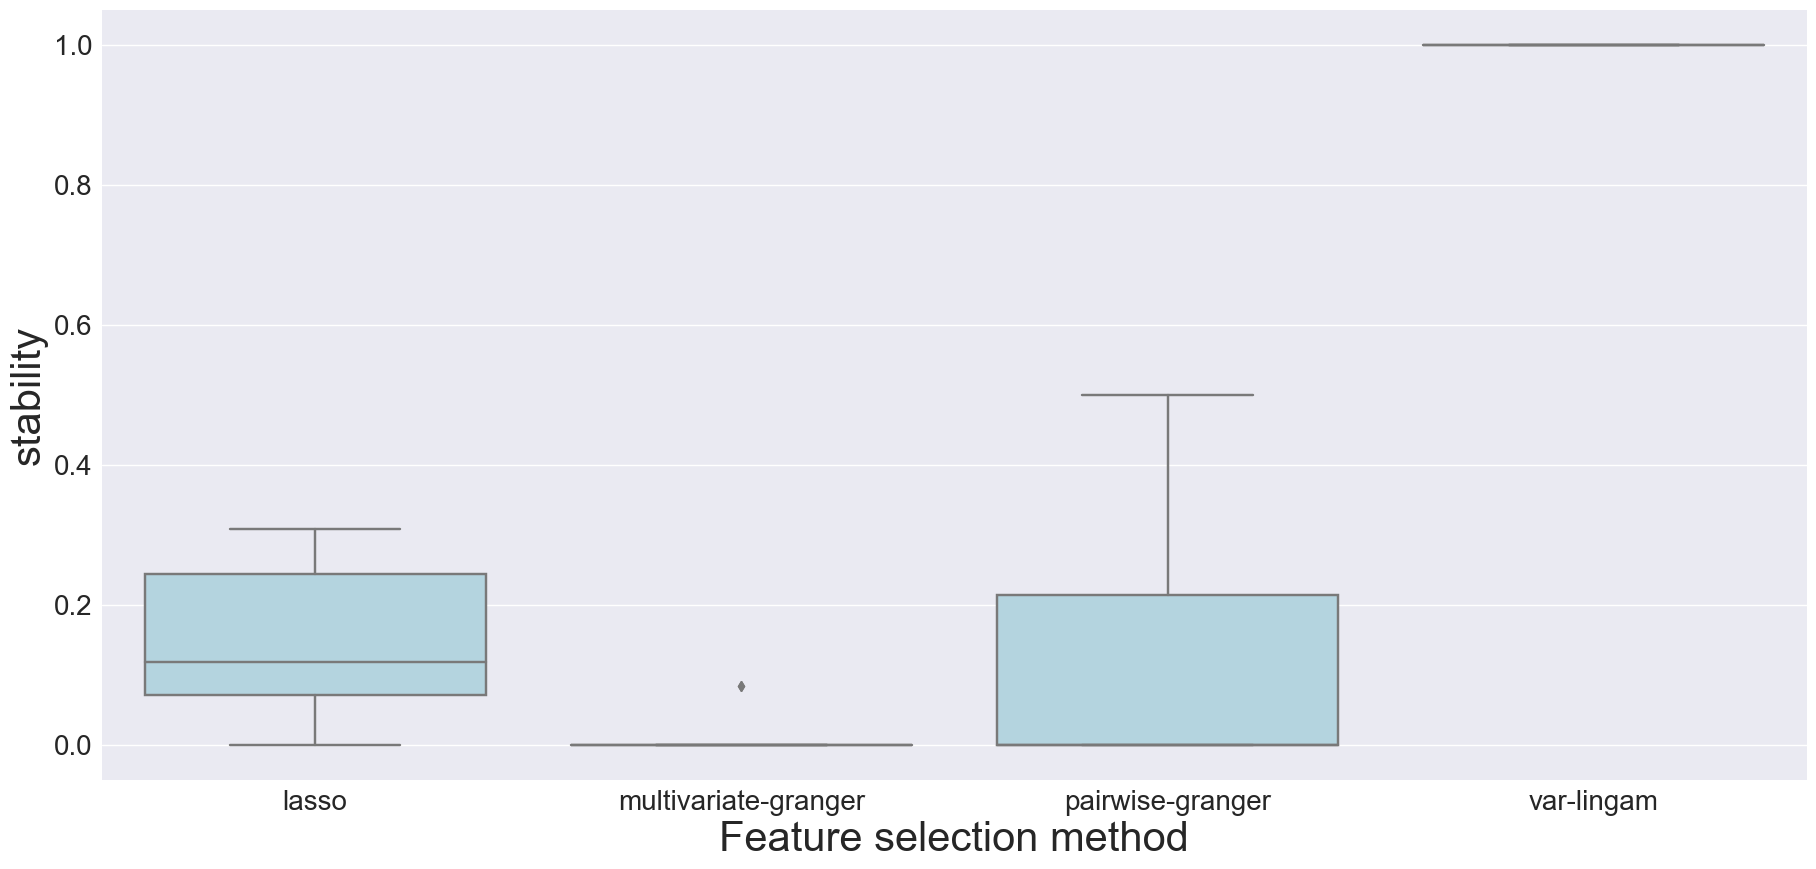

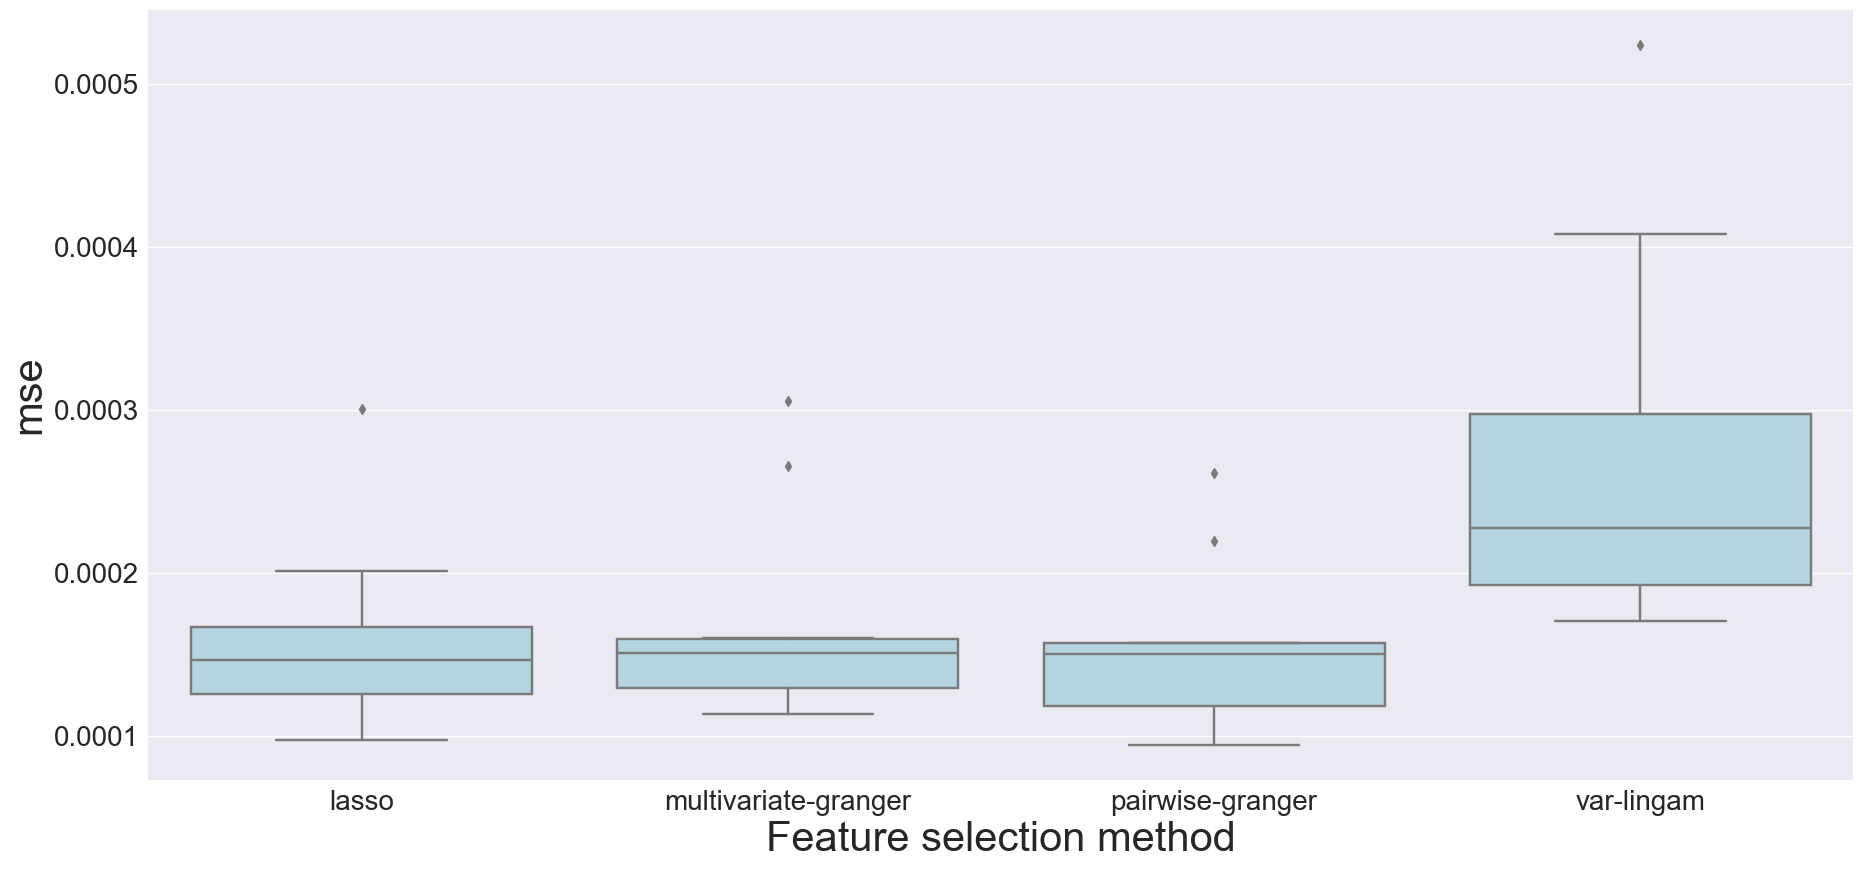

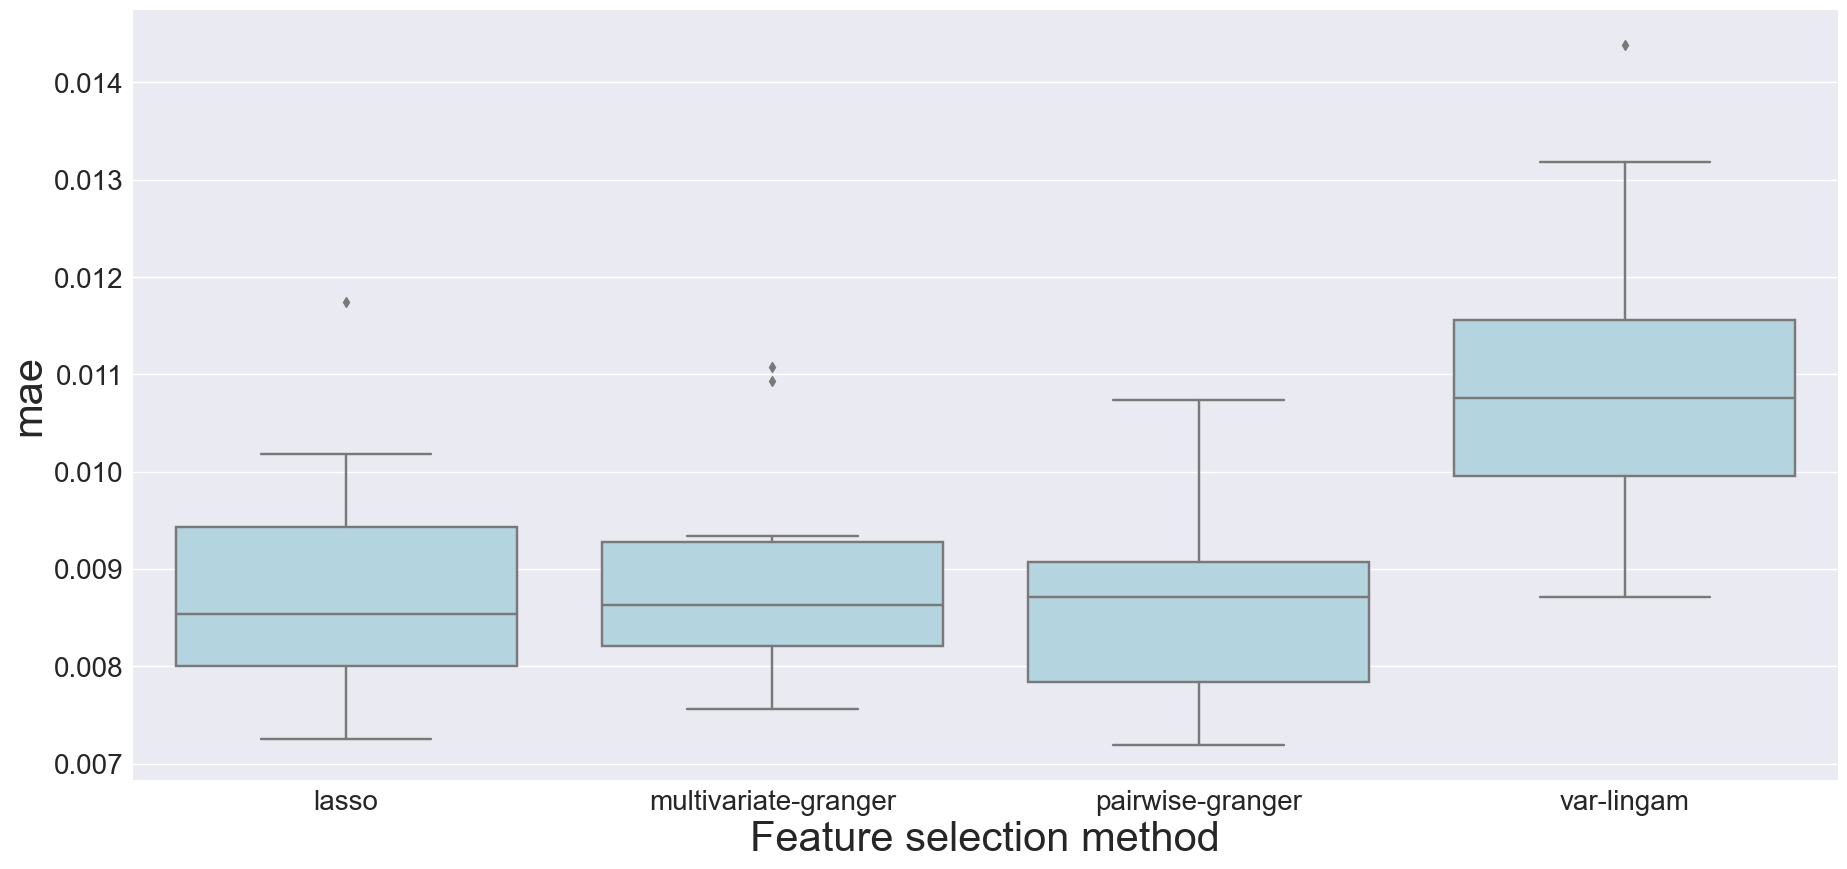

In [4]:
metric_name = "mse"
for m in metric_names:
    boxplot_df = melted_all_metrics_df.loc[(melted_all_metrics_df["variable"] == m)].drop(["variable"], axis=1)

    fig, ax = plt.subplots(figsize=(22, 10))
    sns.boxplot(x="fs", y='value',data=boxplot_df, ax=ax, color='lightblue')
    ax.set_ylabel(m, fontsize=30)
    ax.set_xlabel("Feature selection method", fontsize=30)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    # ax.legend(loc="best",fontsize=15)
    # fig.savefig('img/oos_auc_fs_methods_distr.png')

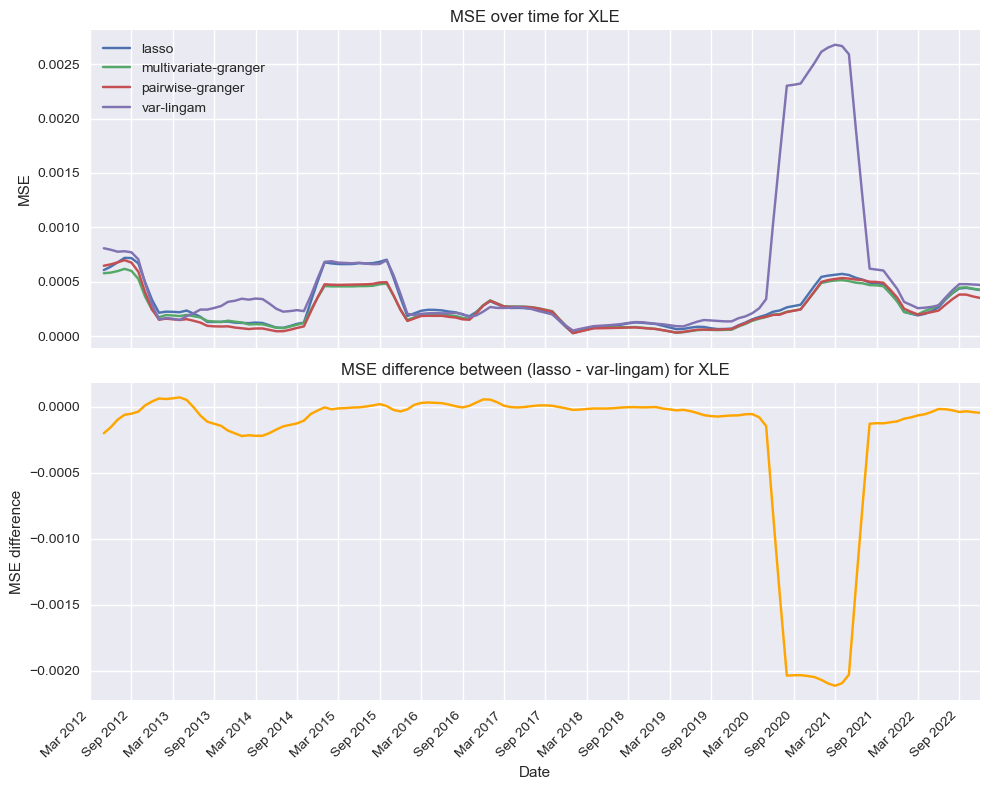

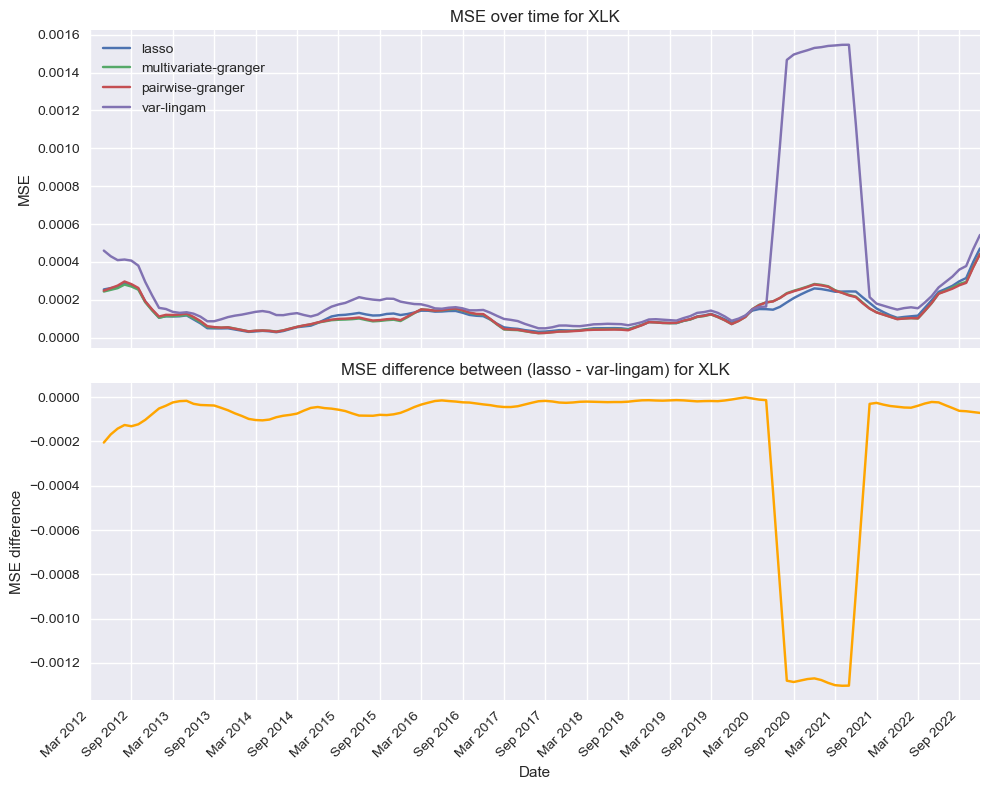

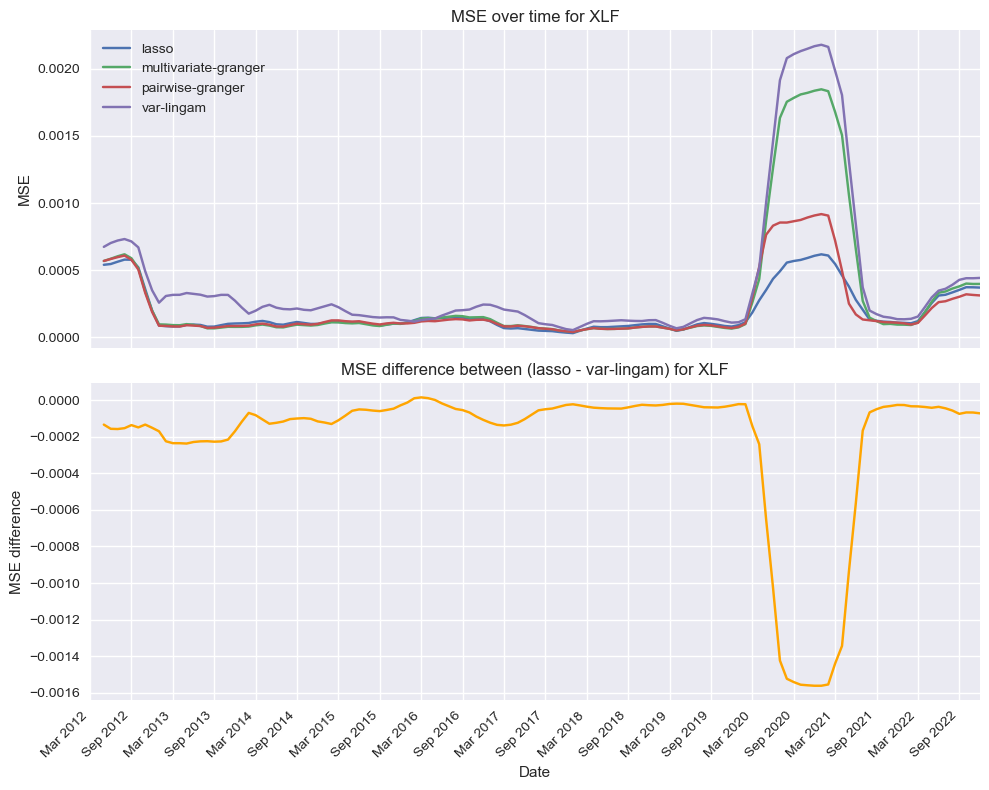

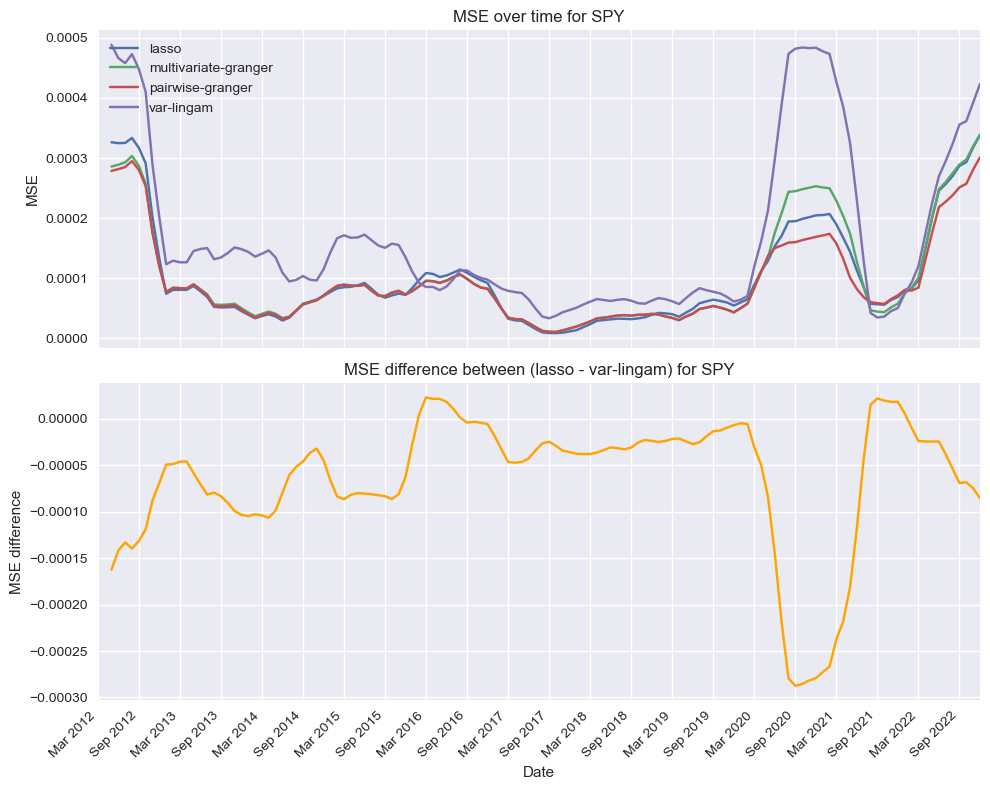

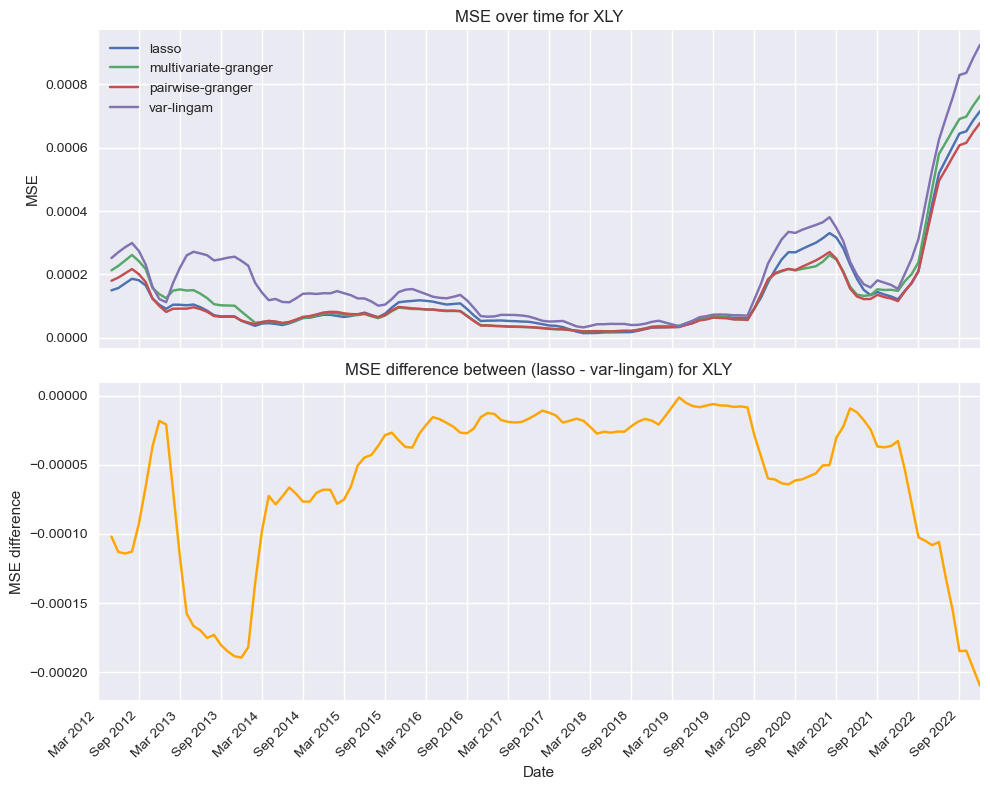

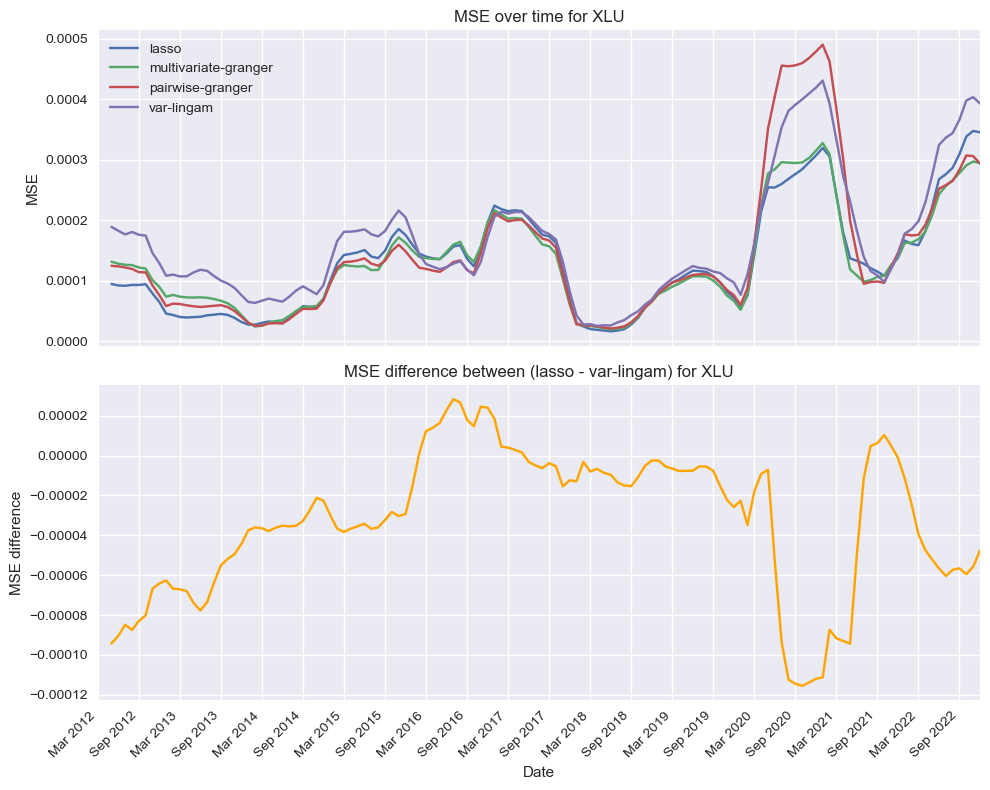

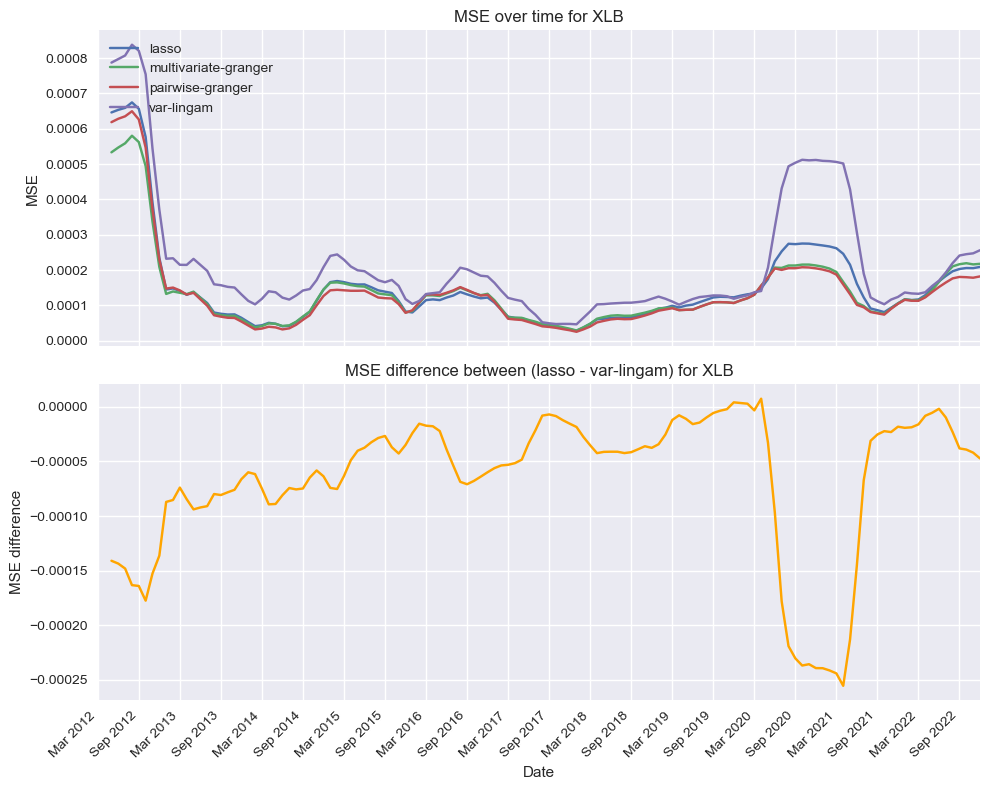

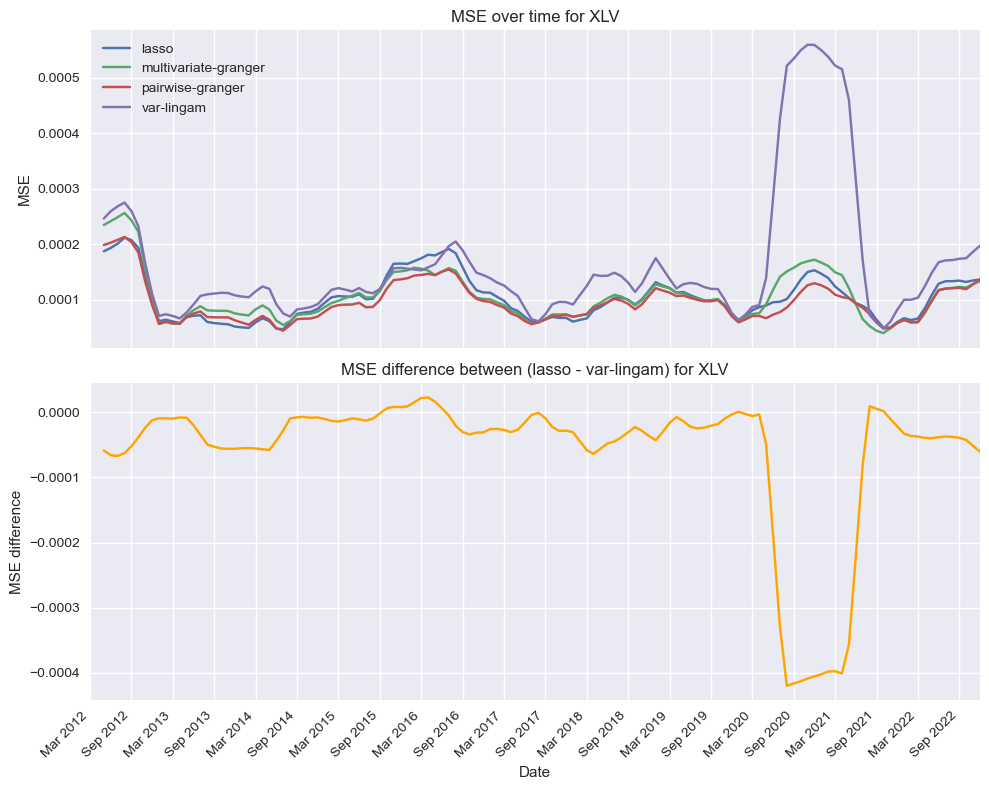

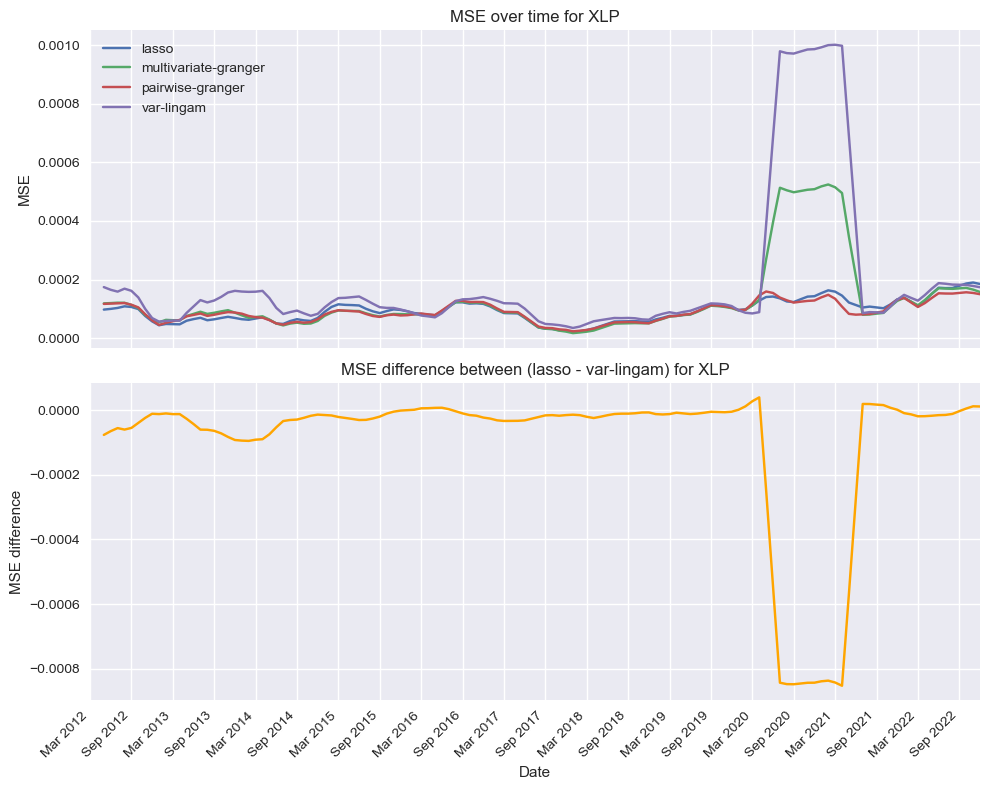

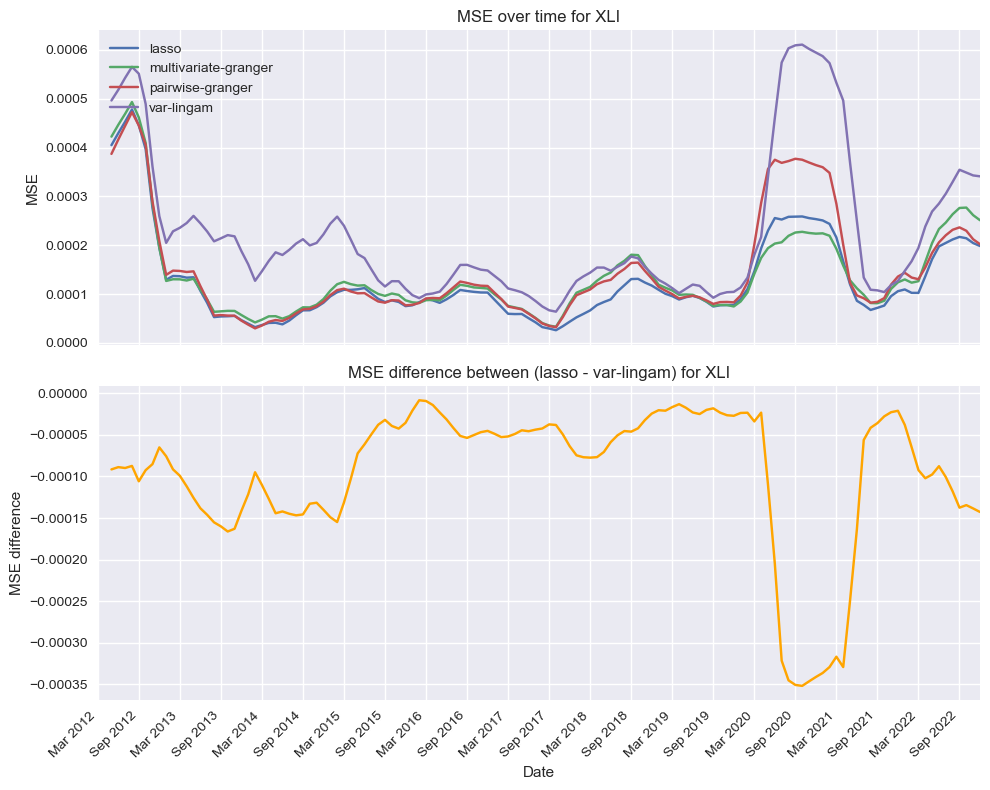

In [5]:
# SPY, XLP, XLK, XLY, XLF, XLB, XLI 

for etf in all_rolling_metrics_df["etf"].unique():
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df = etf_rolling_metrics_df.rolling(3).mean()
    etf_rolling_metrics_df["diff_lasso_var-lingam"] = etf_rolling_metrics_df["lasso"] - etf_rolling_metrics_df["var-lingam"]

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting on the upper subplot
    etf_rolling_metrics_df.drop(["diff_lasso_var-lingam"], axis=1).plot(ax=axs[0])
    axs[0].set_title(f'MSE over time for {etf}')
    axs[0].set_ylabel('MSE')
    axs[0].legend(loc='upper left')

    # Plotting on the lower subplot
    etf_rolling_metrics_df["diff_lasso_var-lingam"].plot(ax=axs[1], color='orange')
    axs[1].set_title(f'MSE difference between (lasso - var-lingam) for {etf}')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('MSE difference')

    # Adding months and years to the index of the plot
    tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
    axs[1].set_xticks(tick_positions)
    axs[1].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the plot
    plt.show()

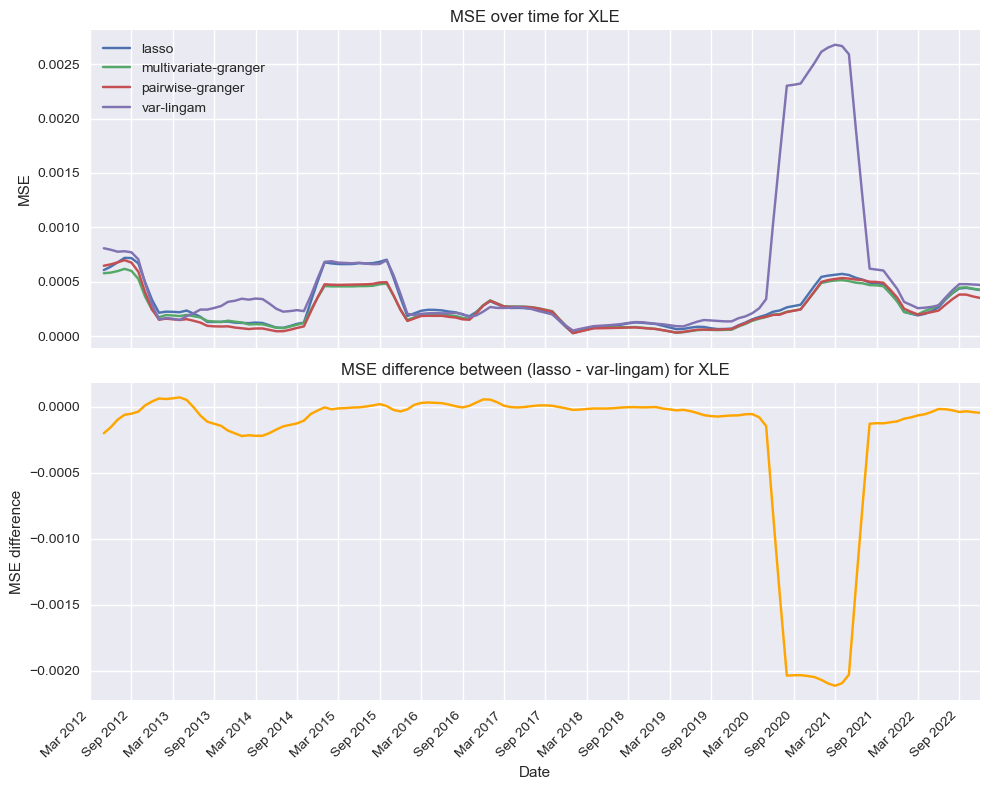

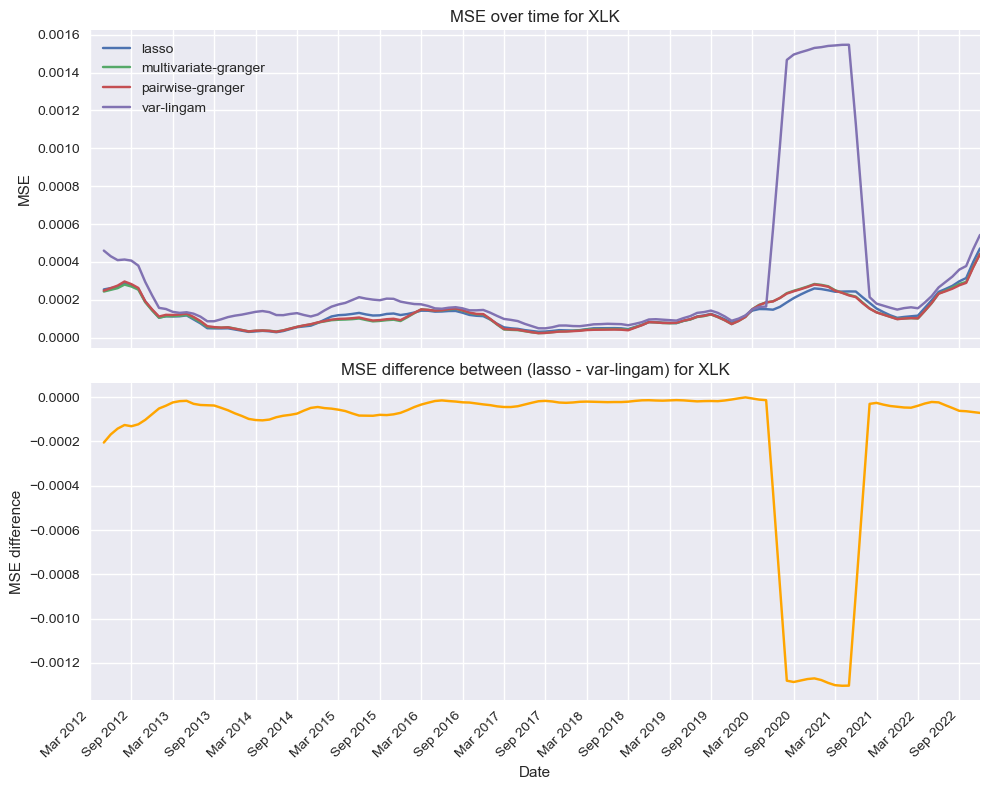

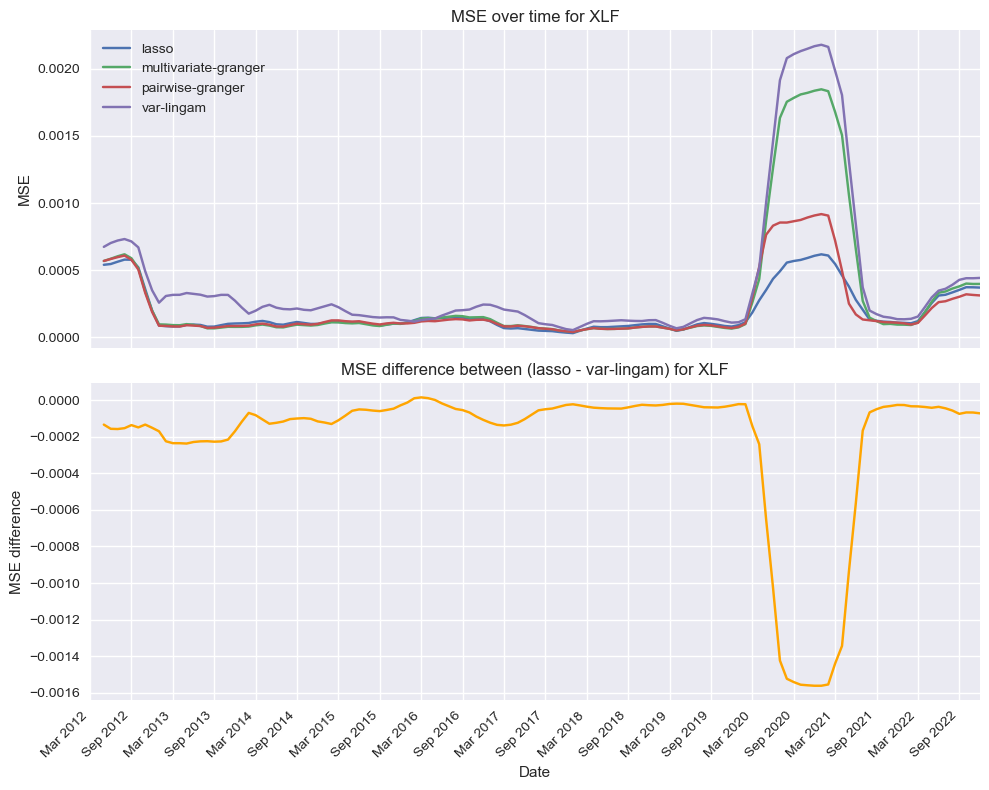

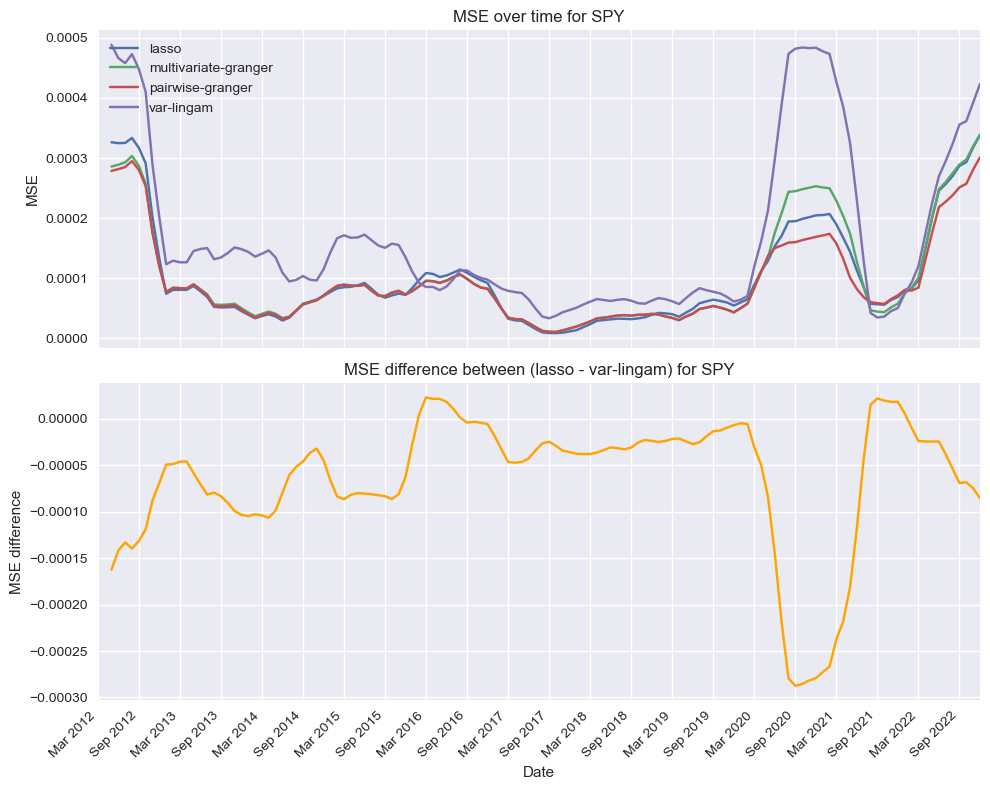

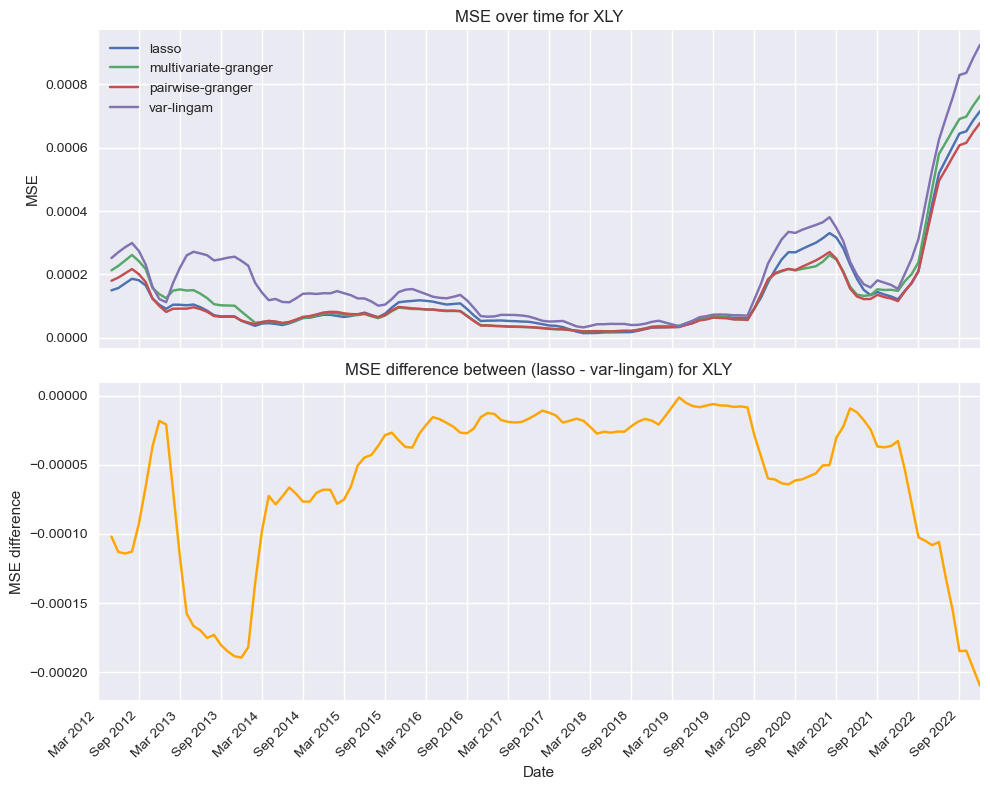

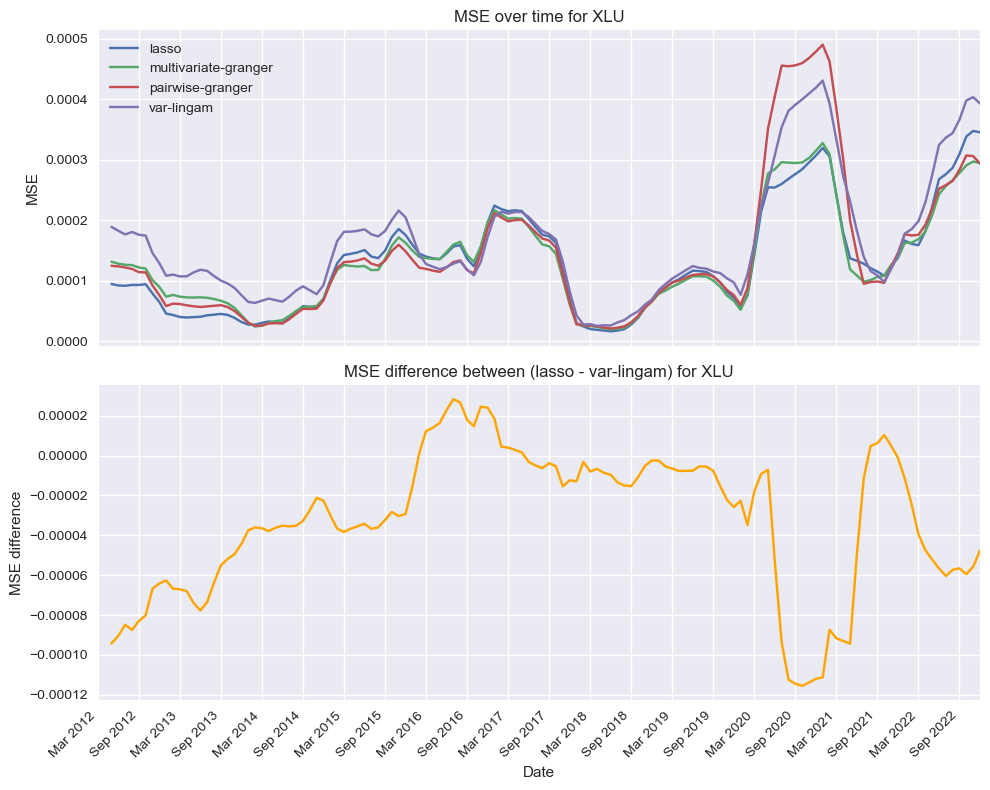

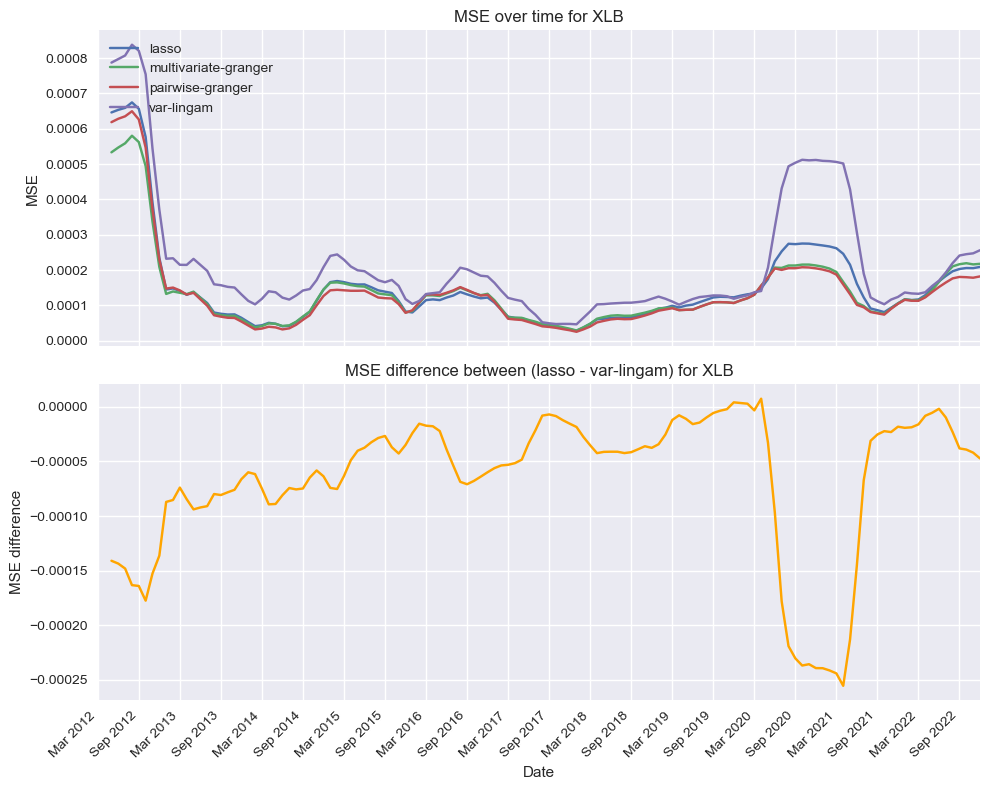

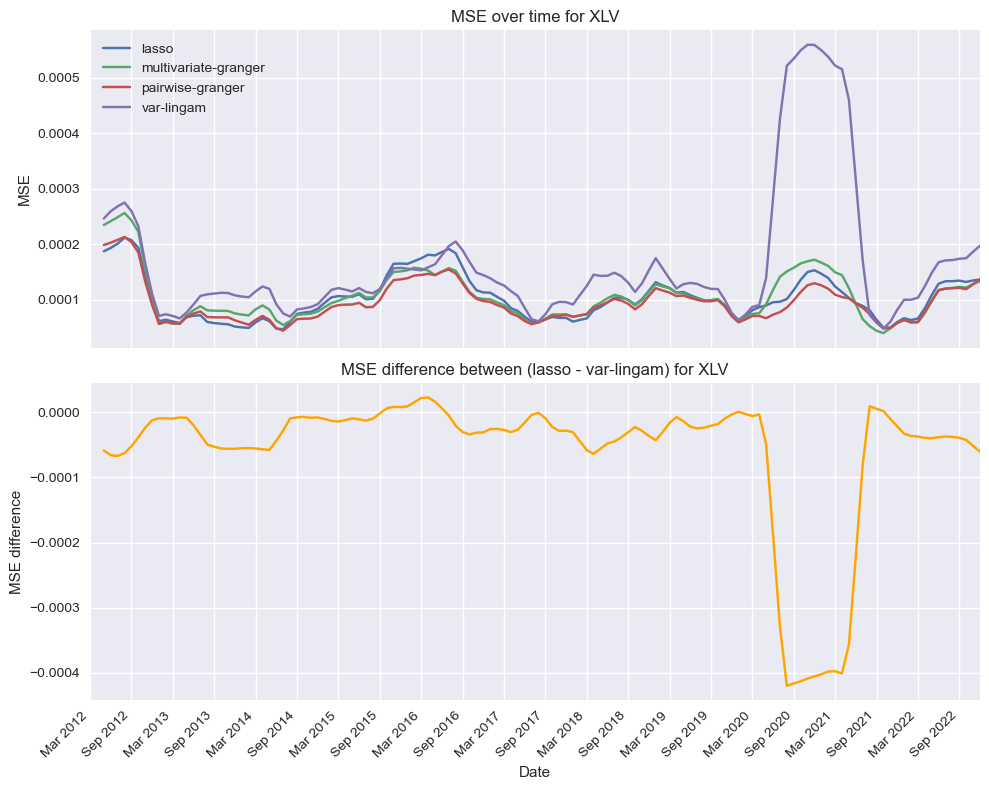

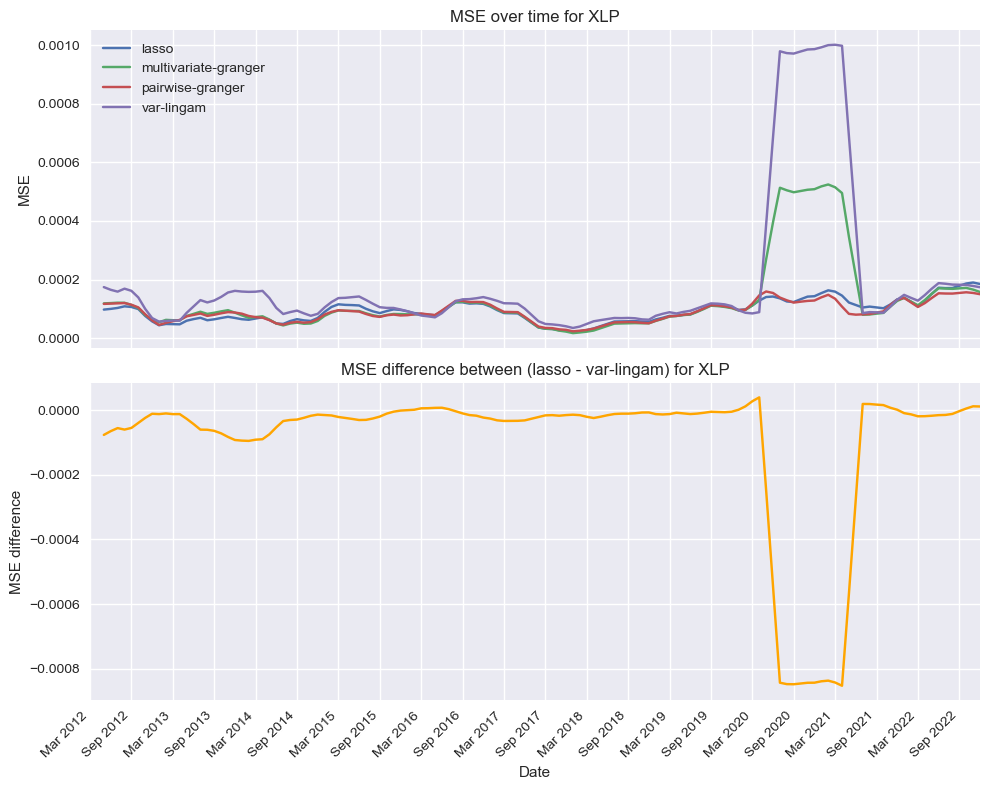

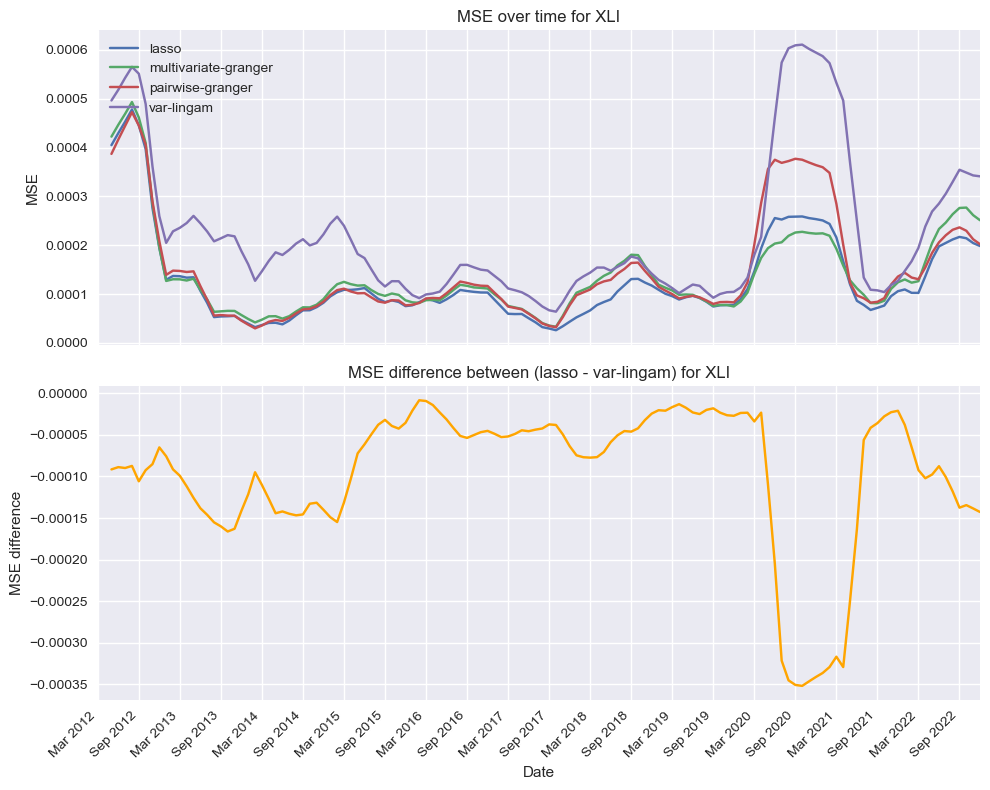

In [6]:
# SPY, XLP, XLK, XLY, XLF, XLB, XLI 

for etf in all_rolling_metrics_df["etf"].unique():
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df = etf_rolling_metrics_df.rolling(3).mean().loc["2010-01-01":]
    etf_rolling_metrics_df["diff_lasso_var-lingam"] = etf_rolling_metrics_df["lasso"] - etf_rolling_metrics_df["var-lingam"]

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting on the upper subplot
    etf_rolling_metrics_df.drop(["diff_lasso_var-lingam"], axis=1).plot(ax=axs[0])
    axs[0].set_title(f'MSE over time for {etf}')
    axs[0].set_ylabel('MSE')
    axs[0].legend(loc='upper left')

    # Plotting on the lower subplot
    etf_rolling_metrics_df["diff_lasso_var-lingam"].plot(ax=axs[1], color='orange')
    axs[1].set_title(f'MSE difference between (lasso - var-lingam) for {etf}')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('MSE difference')

    # Adding months and years to the index of the plot
    tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
    axs[1].set_xticks(tick_positions)
    axs[1].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the plot
    plt.show()

In [7]:
all_metrics_df.sort_values(by="mse", ascending=True)

mse       mae  mse_2020  mae_2020  stability
fs                   etf                                                   
pairwise-granger     XLP  0.000095  0.007196  0.000138  0.008520   0.000000
lasso                XLP  0.000098  0.007252  0.000154  0.009291   0.083333
pairwise-granger     XLV  0.000103  0.007670  0.000137  0.009366   0.000000
lasso                XLV  0.000109  0.007886  0.000163  0.010770   0.222222
pairwise-granger     SPY  0.000110  0.007391  0.000182  0.011459   0.000000
multivariate-granger XLV  0.000114  0.008077  0.000184  0.011492   0.000000
                     SPY  0.000120  0.007642  0.000273  0.012962   0.000000
lasso                SPY  0.000121  0.007553  0.000220  0.011582   0.083333
multivariate-granger XLP  0.000127  0.007564  0.000552  0.014286   0.000000
                     XLU  0.000137  0.008619  0.000344  0.012439   0.000000
lasso                XLI  0.000139  0.008508  0.000275  0.013417   0.000000
                     XLU  0.000139  0.008351  0.000335  0.013488   0.250000
pairwise-granger     XLY  0.000144  0.008339  0.000265  0.012694   0.333333
                     XLU  0.000150  0.008763  0.000522  0.017165   0.000000
multivariate-granger XLK  0.000150  0.008623  0.000310  0.014836   0.000000
                     XLI  0.000151  0.009076  0.000243  0.013465   0.000000
pairwise-granger     XLK  0.000151  0.008661  0.000307  0.015088   0.000000
lasso                XLY  0.000154  0.008566  0.000325  0.014244   0.153846
                     XLK  0.000155  0.008805  0.000283  0.014630   0.307692
pairwise-granger     XLI  0.000156  0.008852  0.000396  0.015489   0.285714
multivariate-granger XLB  0.000157  0.009343  0.000230  0.012540   0.000000
pairwise-granger     XLB  0.000157  0.009147  0.000222  0.012137   0.000000
multivariate-granger XLY  0.000160  0.008646  0.000244  0.011678   0.000000
var-lingam           XLV  0.000170  0.009427  0.000608  0.017275   1.000000
lasso                XLB  0.000171  0.009639  0.000295  0.014346   0.000000
var-lingam           XLU  0.000174  0.009931  0.000454  0.017554   1.000000
                     XLP  0.000192  0.008714  0.001074  0.016284   1.000000
                     SPY  0.000196  0.010043  0.000524  0.016588   1.000000
lasso                XLF  0.000201  0.010179  0.000669  0.021865   0.066667
pairwise-granger     XLF  0.000220  0.010163  0.000994  0.024085   0.000000
var-lingam           XLY  0.000220  0.010242  0.000384  0.013786   1.000000
                     XLI  0.000234  0.011263  0.000646  0.019937   1.000000
                     XLB  0.000240  0.011357  0.000561  0.018647   1.000000
pairwise-granger     XLE  0.000261  0.010735  0.000534  0.017007   0.500000
multivariate-granger XLE  0.000266  0.011075  0.000527  0.016799   0.083333
lasso                XLE  0.000301  0.011747  0.000595  0.018641   0.285714
multivariate-granger XLF  0.000306  0.010933  0.002010  0.034334   0.083333
var-lingam           XLK  0.000317  0.011623  0.001669  0.023728   1.000000
                     XLF  0.000408  0.013185  0.002382  0.036665   1.000000
                     XLE  0.000524  0.014390  0.002836  0.034287   1.000000

In [8]:
all_metrics_df.sort_values(by="mae", ascending=True)

mse       mae  mse_2020  mae_2020  stability
fs                   etf                                                   
pairwise-granger     XLP  0.000095  0.007196  0.000138  0.008520   0.000000
lasso                XLP  0.000098  0.007252  0.000154  0.009291   0.083333
pairwise-granger     SPY  0.000110  0.007391  0.000182  0.011459   0.000000
lasso                SPY  0.000121  0.007553  0.000220  0.011582   0.083333
multivariate-granger XLP  0.000127  0.007564  0.000552  0.014286   0.000000
                     SPY  0.000120  0.007642  0.000273  0.012962   0.000000
pairwise-granger     XLV  0.000103  0.007670  0.000137  0.009366   0.000000
lasso                XLV  0.000109  0.007886  0.000163  0.010770   0.222222
multivariate-granger XLV  0.000114  0.008077  0.000184  0.011492   0.000000
pairwise-granger     XLY  0.000144  0.008339  0.000265  0.012694   0.333333
lasso                XLU  0.000139  0.008351  0.000335  0.013488   0.250000
                     XLI  0.000139  0.008508  0.000275  0.013417   0.000000
                     XLY  0.000154  0.008566  0.000325  0.014244   0.153846
multivariate-granger XLU  0.000137  0.008619  0.000344  0.012439   0.000000
                     XLK  0.000150  0.008623  0.000310  0.014836   0.000000
                     XLY  0.000160  0.008646  0.000244  0.011678   0.000000
pairwise-granger     XLK  0.000151  0.008661  0.000307  0.015088   0.000000
var-lingam           XLP  0.000192  0.008714  0.001074  0.016284   1.000000
pairwise-granger     XLU  0.000150  0.008763  0.000522  0.017165   0.000000
lasso                XLK  0.000155  0.008805  0.000283  0.014630   0.307692
pairwise-granger     XLI  0.000156  0.008852  0.000396  0.015489   0.285714
multivariate-granger XLI  0.000151  0.009076  0.000243  0.013465   0.000000
pairwise-granger     XLB  0.000157  0.009147  0.000222  0.012137   0.000000
multivariate-granger XLB  0.000157  0.009343  0.000230  0.012540   0.000000
var-lingam           XLV  0.000170  0.009427  0.000608  0.017275   1.000000
lasso                XLB  0.000171  0.009639  0.000295  0.014346   0.000000
var-lingam           XLU  0.000174  0.009931  0.000454  0.017554   1.000000
                     SPY  0.000196  0.010043  0.000524  0.016588   1.000000
pairwise-granger     XLF  0.000220  0.010163  0.000994  0.024085   0.000000
lasso                XLF  0.000201  0.010179  0.000669  0.021865   0.066667
var-lingam           XLY  0.000220  0.010242  0.000384  0.013786   1.000000
pairwise-granger     XLE  0.000261  0.010735  0.000534  0.017007   0.500000
multivariate-granger XLF  0.000306  0.010933  0.002010  0.034334   0.083333
                     XLE  0.000266  0.011075  0.000527  0.016799   0.083333
var-lingam           XLI  0.000234  0.011263  0.000646  0.019937   1.000000
                     XLB  0.000240  0.011357  0.000561  0.018647   1.000000
                     XLK  0.000317  0.011623  0.001669  0.023728   1.000000
lasso                XLE  0.000301  0.011747  0.000595  0.018641   0.285714
var-lingam           XLF  0.000408  0.013185  0.002382  0.036665   1.000000
                     XLE  0.000524  0.014390  0.002836  0.034287   1.000000

In [9]:
all_metrics_df.sort_values(by="stability", ascending=False)

mse       mae  mse_2020  mae_2020  stability
fs                   etf                                                   
var-lingam           XLI  0.000234  0.011263  0.000646  0.019937   1.000000
                     XLE  0.000524  0.014390  0.002836  0.034287   1.000000
                     XLP  0.000192  0.008714  0.001074  0.016284   1.000000
                     XLV  0.000170  0.009427  0.000608  0.017275   1.000000
                     XLB  0.000240  0.011357  0.000561  0.018647   1.000000
                     XLU  0.000174  0.009931  0.000454  0.017554   1.000000
                     XLY  0.000220  0.010242  0.000384  0.013786   1.000000
                     SPY  0.000196  0.010043  0.000524  0.016588   1.000000
                     XLF  0.000408  0.013185  0.002382  0.036665   1.000000
                     XLK  0.000317  0.011623  0.001669  0.023728   1.000000
pairwise-granger     XLE  0.000261  0.010735  0.000534  0.017007   0.500000
                     XLY  0.000144  0.008339  0.000265  0.012694   0.333333
lasso                XLK  0.000155  0.008805  0.000283  0.014630   0.307692
                     XLE  0.000301  0.011747  0.000595  0.018641   0.285714
pairwise-granger     XLI  0.000156  0.008852  0.000396  0.015489   0.285714
lasso                XLU  0.000139  0.008351  0.000335  0.013488   0.250000
                     XLV  0.000109  0.007886  0.000163  0.010770   0.222222
                     XLY  0.000154  0.008566  0.000325  0.014244   0.153846
                     SPY  0.000121  0.007553  0.000220  0.011582   0.083333
                     XLP  0.000098  0.007252  0.000154  0.009291   0.083333
multivariate-granger XLE  0.000266  0.011075  0.000527  0.016799   0.083333
                     XLF  0.000306  0.010933  0.002010  0.034334   0.083333
lasso                XLF  0.000201  0.010179  0.000669  0.021865   0.066667
pairwise-granger     XLV  0.000103  0.007670  0.000137  0.009366   0.000000
lasso                XLB  0.000171  0.009639  0.000295  0.014346   0.000000
                     XLI  0.000139  0.008508  0.000275  0.013417   0.000000
pairwise-granger     XLP  0.000095  0.007196  0.000138  0.008520   0.000000
multivariate-granger XLK  0.000150  0.008623  0.000310  0.014836   0.000000
pairwise-granger     XLB  0.000157  0.009147  0.000222  0.012137   0.000000
                     SPY  0.000110  0.007391  0.000182  0.011459   0.000000
                     XLF  0.000220  0.010163  0.000994  0.024085   0.000000
                     XLK  0.000151  0.008661  0.000307  0.015088   0.000000
multivariate-granger XLI  0.000151  0.009076  0.000243  0.013465   0.000000
                     XLP  0.000127  0.007564  0.000552  0.014286   0.000000
                     XLV  0.000114  0.008077  0.000184  0.011492   0.000000
                     XLB  0.000157  0.009343  0.000230  0.012540   0.000000
                     XLU  0.000137  0.008619  0.000344  0.012439   0.000000
                     XLY  0.000160  0.008646  0.000244  0.011678   0.000000
                     SPY  0.000120  0.007642  0.000273  0.012962   0.000000
pairwise-granger     XLU  0.000150  0.008763  0.000522  0.017165   0.000000

In [10]:
all_metrics_df.sort_values(by="mse_2020", ascending=True)

mse       mae  mse_2020  mae_2020  stability
fs                   etf                                                   
pairwise-granger     XLV  0.000103  0.007670  0.000137  0.009366   0.000000
                     XLP  0.000095  0.007196  0.000138  0.008520   0.000000
lasso                XLP  0.000098  0.007252  0.000154  0.009291   0.083333
                     XLV  0.000109  0.007886  0.000163  0.010770   0.222222
pairwise-granger     SPY  0.000110  0.007391  0.000182  0.011459   0.000000
multivariate-granger XLV  0.000114  0.008077  0.000184  0.011492   0.000000
lasso                SPY  0.000121  0.007553  0.000220  0.011582   0.083333
pairwise-granger     XLB  0.000157  0.009147  0.000222  0.012137   0.000000
multivariate-granger XLB  0.000157  0.009343  0.000230  0.012540   0.000000
                     XLI  0.000151  0.009076  0.000243  0.013465   0.000000
                     XLY  0.000160  0.008646  0.000244  0.011678   0.000000
pairwise-granger     XLY  0.000144  0.008339  0.000265  0.012694   0.333333
multivariate-granger SPY  0.000120  0.007642  0.000273  0.012962   0.000000
lasso                XLI  0.000139  0.008508  0.000275  0.013417   0.000000
                     XLK  0.000155  0.008805  0.000283  0.014630   0.307692
                     XLB  0.000171  0.009639  0.000295  0.014346   0.000000
pairwise-granger     XLK  0.000151  0.008661  0.000307  0.015088   0.000000
multivariate-granger XLK  0.000150  0.008623  0.000310  0.014836   0.000000
lasso                XLY  0.000154  0.008566  0.000325  0.014244   0.153846
                     XLU  0.000139  0.008351  0.000335  0.013488   0.250000
multivariate-granger XLU  0.000137  0.008619  0.000344  0.012439   0.000000
var-lingam           XLY  0.000220  0.010242  0.000384  0.013786   1.000000
pairwise-granger     XLI  0.000156  0.008852  0.000396  0.015489   0.285714
var-lingam           XLU  0.000174  0.009931  0.000454  0.017554   1.000000
pairwise-granger     XLU  0.000150  0.008763  0.000522  0.017165   0.000000
var-lingam           SPY  0.000196  0.010043  0.000524  0.016588   1.000000
multivariate-granger XLE  0.000266  0.011075  0.000527  0.016799   0.083333
pairwise-granger     XLE  0.000261  0.010735  0.000534  0.017007   0.500000
multivariate-granger XLP  0.000127  0.007564  0.000552  0.014286   0.000000
var-lingam           XLB  0.000240  0.011357  0.000561  0.018647   1.000000
lasso                XLE  0.000301  0.011747  0.000595  0.018641   0.285714
var-lingam           XLV  0.000170  0.009427  0.000608  0.017275   1.000000
                     XLI  0.000234  0.011263  0.000646  0.019937   1.000000
lasso                XLF  0.000201  0.010179  0.000669  0.021865   0.066667
pairwise-granger     XLF  0.000220  0.010163  0.000994  0.024085   0.000000
var-lingam           XLP  0.000192  0.008714  0.001074  0.016284   1.000000
                     XLK  0.000317  0.011623  0.001669  0.023728   1.000000
multivariate-granger XLF  0.000306  0.010933  0.002010  0.034334   0.083333
var-lingam           XLF  0.000408  0.013185  0.002382  0.036665   1.000000
                     XLE  0.000524  0.014390  0.002836  0.034287   1.000000

In [11]:
all_metrics_df.sort_values(by="mse", ascending=True)

mse       mae  mse_2020  mae_2020  stability
fs                   etf                                                   
pairwise-granger     XLP  0.000095  0.007196  0.000138  0.008520   0.000000
lasso                XLP  0.000098  0.007252  0.000154  0.009291   0.083333
pairwise-granger     XLV  0.000103  0.007670  0.000137  0.009366   0.000000
lasso                XLV  0.000109  0.007886  0.000163  0.010770   0.222222
pairwise-granger     SPY  0.000110  0.007391  0.000182  0.011459   0.000000
multivariate-granger XLV  0.000114  0.008077  0.000184  0.011492   0.000000
                     SPY  0.000120  0.007642  0.000273  0.012962   0.000000
lasso                SPY  0.000121  0.007553  0.000220  0.011582   0.083333
multivariate-granger XLP  0.000127  0.007564  0.000552  0.014286   0.000000
                     XLU  0.000137  0.008619  0.000344  0.012439   0.000000
lasso                XLI  0.000139  0.008508  0.000275  0.013417   0.000000
                     XLU  0.000139  0.008351  0.000335  0.013488   0.250000
pairwise-granger     XLY  0.000144  0.008339  0.000265  0.012694   0.333333
                     XLU  0.000150  0.008763  0.000522  0.017165   0.000000
multivariate-granger XLK  0.000150  0.008623  0.000310  0.014836   0.000000
                     XLI  0.000151  0.009076  0.000243  0.013465   0.000000
pairwise-granger     XLK  0.000151  0.008661  0.000307  0.015088   0.000000
lasso                XLY  0.000154  0.008566  0.000325  0.014244   0.153846
                     XLK  0.000155  0.008805  0.000283  0.014630   0.307692
pairwise-granger     XLI  0.000156  0.008852  0.000396  0.015489   0.285714
multivariate-granger XLB  0.000157  0.009343  0.000230  0.012540   0.000000
pairwise-granger     XLB  0.000157  0.009147  0.000222  0.012137   0.000000
multivariate-granger XLY  0.000160  0.008646  0.000244  0.011678   0.000000
var-lingam           XLV  0.000170  0.009427  0.000608  0.017275   1.000000
lasso                XLB  0.000171  0.009639  0.000295  0.014346   0.000000
var-lingam           XLU  0.000174  0.009931  0.000454  0.017554   1.000000
                     XLP  0.000192  0.008714  0.001074  0.016284   1.000000
                     SPY  0.000196  0.010043  0.000524  0.016588   1.000000
lasso                XLF  0.000201  0.010179  0.000669  0.021865   0.066667
pairwise-granger     XLF  0.000220  0.010163  0.000994  0.024085   0.000000
var-lingam           XLY  0.000220  0.010242  0.000384  0.013786   1.000000
                     XLI  0.000234  0.011263  0.000646  0.019937   1.000000
                     XLB  0.000240  0.011357  0.000561  0.018647   1.000000
pairwise-granger     XLE  0.000261  0.010735  0.000534  0.017007   0.500000
multivariate-granger XLE  0.000266  0.011075  0.000527  0.016799   0.083333
lasso                XLE  0.000301  0.011747  0.000595  0.018641   0.285714
multivariate-granger XLF  0.000306  0.010933  0.002010  0.034334   0.083333
var-lingam           XLK  0.000317  0.011623  0.001669  0.023728   1.000000
                     XLF  0.000408  0.013185  0.002382  0.036665   1.000000
                     XLE  0.000524  0.014390  0.002836  0.034287   1.000000

<AxesSubplot:xlabel='stability', ylabel='mae'>

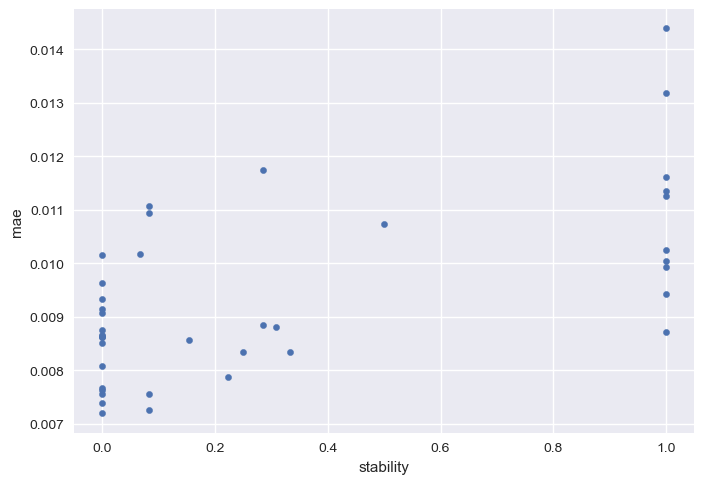

In [12]:
all_metrics_df.plot.scatter(y="mae", x="stability")

<AxesSubplot:xlabel='stability', ylabel='mae_2020'>

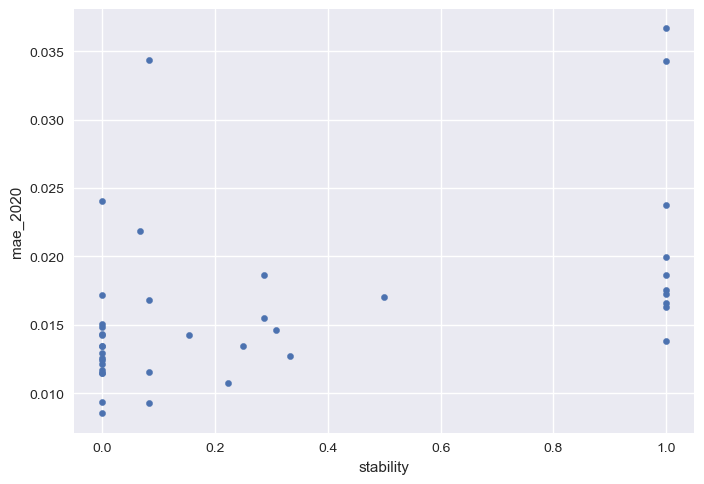

In [13]:
all_metrics_df.plot.scatter(y="mae_2020", x="stability")

<AxesSubplot:xlabel='stability', ylabel='mse'>

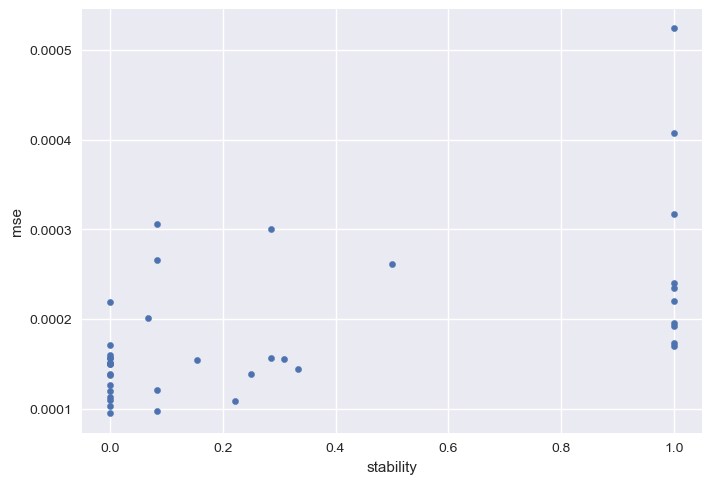

In [14]:
all_metrics_df.plot.scatter(y="mse", x="stability")

<AxesSubplot:xlabel='stability', ylabel='mse_2020'>

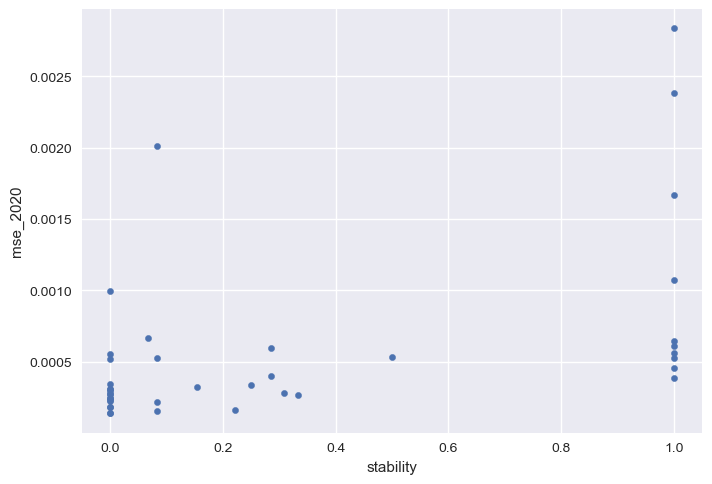

In [15]:
all_metrics_df.plot.scatter(y="mse_2020", x="stability")